# Exploratory data analysis of patches

In [1]:
import numpy as np
import pandas as pd
import editdistance
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import seaborn as sns

from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

sns.set_theme(style="darkgrid")

## Simple case study
This case study loads data coming from one page and plot distribution of the patches coordinates. We can see that we have bins that should corresponds to columns

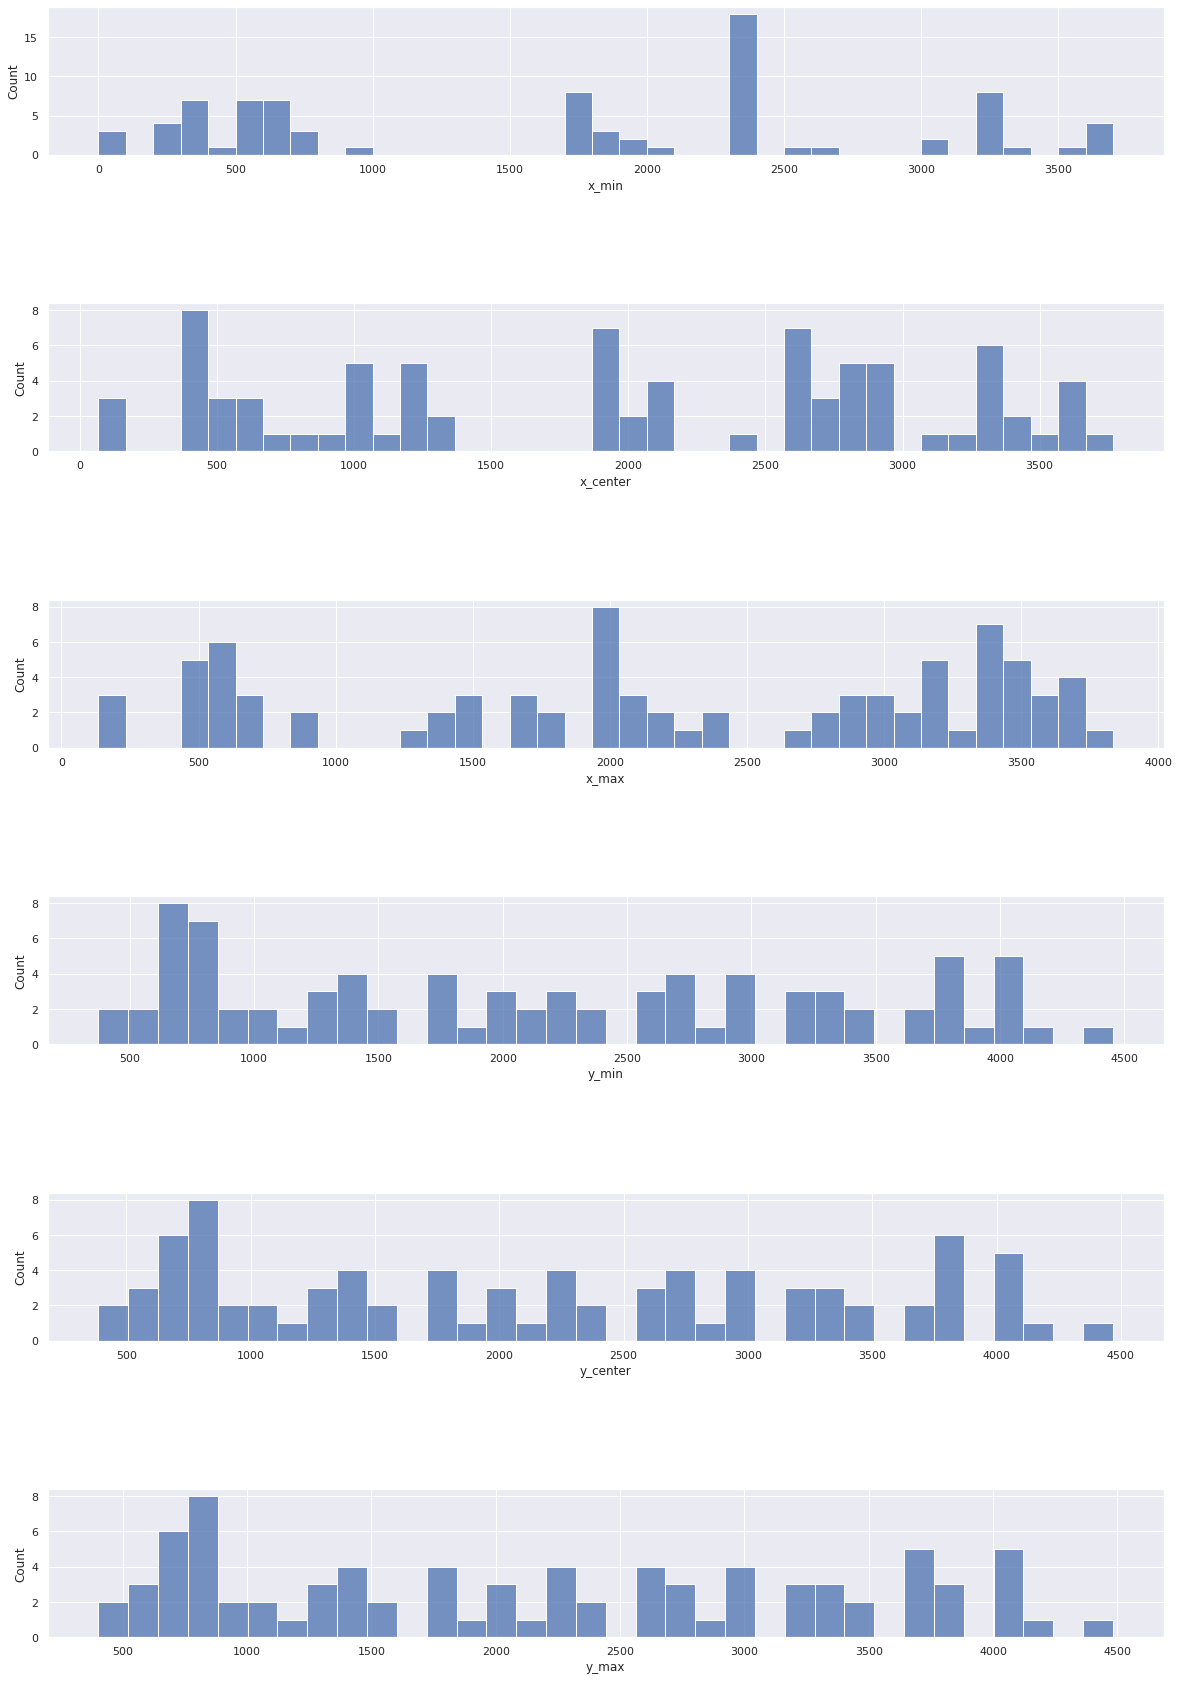

In [2]:
df = pd.read_csv("/dhlabdata4/mion/P2PaLA/work/results/prod/dataframe/Censo-stabile_Sommarioni-napoleonici_reg-1_0157_155.csv")

df['x_center'] = (df['x_min']+df['x_max'])/2.0
df['y_center'] = (df['y_min']+df['y_max'])/2.0

x_binwidth = 100
y_binwidth = 120
plots=["x_min","x_center", "x_max","y_min", "y_center", "y_max"]
binwidths = {"x_min":x_binwidth,"x_center":x_binwidth, "x_max":x_binwidth,"y_min":y_binwidth, "y_center":y_binwidth, "y_max":y_binwidth}
fig, axes = plt.subplots(nrows=len(plots), ncols=1, figsize=(20,30))
plt.subplots_adjust(hspace=1)
for i,plot in enumerate(plots):
    sns.histplot(data=df, x=plot, binwidth= binwidths[plot], ax= axes[i]) 
plt.show()

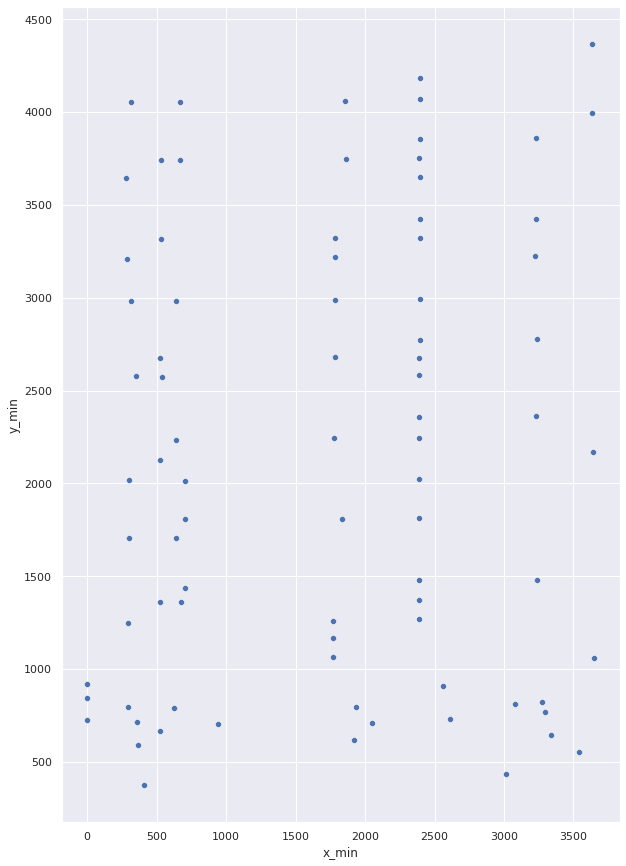

In [3]:
plt.figure(figsize=(10,15))
sns.scatterplot(data=df, x="x_min", y='y_min')
plt.show()

## Analysis of the column number 

### Data loading

In [4]:
registers = ['reg01', 'reg02', 'reg03', 'reg04', 'reg05', 'reg06', 'reg06bis', 'reg07']
encoding = 'utf-8'
path_segmentation = '/dhlabdata4/mion/P2PaLA/sommarioniProcessed'
path_htr = '/dhlabdata4/mion/PyLaia/egs/decipher-venice/data/sommarioni'
path_original_img = '/dhlabdata4/sommarioni'

In [5]:
def replace_quondam(s):
    return s.replace('quondam', 'q.')

def clean_excel(excel):
    excel["denom_pezzi_di_terra"] = excel["denom_pezzi_di_terra"].apply(lambda x: str(x).replace(";", " "))
    excel["possessore"] = excel["possessore"].apply(lambda x: replace_quondam(str(x)))
    return excel.drop(columns=['Unnamed: 0'])

def clean_result_htr(result_htr):
    result_htr["cleaned"] = result_htr["cleaned"].apply(lambda x: replace_quondam(str(x)))
    result_htr = result_htr.dropna()
    result_htr = result_htr[result_htr['cleaned']!='nan']
    result_htr['id'] = result_htr["id"].apply(lambda x: str(x)+'.jpg')
    return result_htr

def clean_metadata(metadata):
    # the page name must finish with a number
    metadata['last_token'] = metadata['page_name'].str.split('_').apply(lambda x : x[-1].split('.')[0])
    metadata = metadata[metadata['last_token'].str.isnumeric()==True].drop(columns=['last_token'])
    return metadata.drop(columns=['Unnamed: 0'])

def remove_numeric_htr_result(result_htr):
    return result_htr[result_htr['cleaned'].str.isnumeric()==False]

def remove_one_letter_htr_result(result_htr):
    return result_htr[result_htr['cleaned'].str.len() > 1]

def show_sommarioni(pageID, register):
    path_original_img_reg = os.path.join(path_original_img, register)
    path_image = os.path.join(path_original_img_reg, pageID+'.jpg')
    img = mpimg.imread(path_image)
    fig= plt.figure(figsize=(20,15))
    plt.imshow(img) 
    plt.show()
    
def extract_page(index, result_htr, metadata):
    patch_id = result_htr['id'].iloc[index]
    return metadata[metadata['filename']==patch_id]['page_name'].iloc[0]

In [6]:
result_htr = pd.DataFrame()
metadata = pd.DataFrame()
htr_metadata = pd.DataFrame()

for register in registers:
    path_htr_register = os.path.join(path_htr,register)
    path_segmentation_htr = os.path.join(path_segmentation, register)
    result_htr_reg = clean_result_htr(pd.read_csv(os.path.join(path_htr_register,'patches_'+register+'.csv')))
    
    metadata_path = os.path.join(path_segmentation_htr,'results/prod/dataframe')
    csv_files=os.listdir(metadata_path)
    metadata_reg = pd.read_csv(os.path.join(metadata_path,csv_files[0]), encoding=encoding)
    for f  in csv_files[1:]:
        metadata_reg = metadata_reg.append(pd.read_csv(os.path.join(metadata_path,f), encoding=encoding))
    metadata_reg = clean_metadata(metadata_reg)
    htr_metadata_reg = result_htr_reg.join(metadata_reg.set_index('filename'), on='id', how='inner')
    htr_metadata_reg['register'] = register
    
    result_htr = result_htr.append(result_htr_reg)
    metadata = metadata.append(metadata_reg) 
    htr_metadata = htr_metadata.append(htr_metadata_reg)
htr_metadata['collumn_number']=htr_metadata['collumn_number'].astype(int)
htr_metadata = htr_metadata.reset_index()\
                           .drop(columns=['index'])

### Function to extract stats

In [7]:
def extract_column_htr(htr_data, col_number):
    return htr_data[htr_data['collumn_number']==col_number]['cleaned']

def stats_length_column(htr_data, col_number):
    col = extract_column_htr(htr_data, col_number)
    return col.apply(lambda x : len(str(x))).describe()

def mean_length_column(htr_data, col_number):
    stats = stats_length_column(htr_data, col_number)
    if 'mean' in stats:
        return stats['mean']
    return np.NaN

def mean_length_colum_vector(htr_data):
    vector = {}
    for c in range(htr_data['collumn_number'].max()+1):
        vector[c] = mean_length_column(htr_data, c)
    return vector

def mean_length_matrix(htr_metadata):
    feature_m=[]
    for page in tqdm(sorted(htr_metadata['page_name'].unique())):    
        page_htr_metatada = htr_metadata[htr_metadata['page_name']==page]

        feature_v = mean_length_colum_vector(page_htr_metatada)
        feature_v['page_name'] = page
        feature_m.append(feature_v)

    return pd.DataFrame(feature_m).set_index('page_name')

def print_all_mean(htr_data):
    for c in range(htr_data['collumn_number'].max()+1):
        print('Mean length col', c,':',mean_length_column(htr_data, c))

def plot_pca(matrix, axe, hue=0):
    X_pca = PCA(n_components=2).fit_transform(matrix.fillna(0))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],hue=hue, legend='full', hue_order= ['Aligned','Skewed'], ax=axe)
    
def extract_vector(row):
    return np.array(row.drop('cluster')).reshape((1,-1))
def roll_left(vector, means):
    rolled = np.roll(vector, shift=-1)
    rolled[:,-1]=means[-1]
    return rolled

def roll_right(vector, means):
    rolled = np.roll(vector, shift=1)
    rolled[:,0] = means[0]
    return rolled

def compute_fixes(htr_metadata, matrix, kmeans,legend_map):
    means = mean_length_colum_vector(htr_metadata[htr_metadata['register']=='reg01'])
    means = [means[col] for col in means]
    matrix = matrix[matrix['cluster']=='Skewed'].fillna(0)
    fixes = {}
    for i, row in matrix.iterrows():
        vector = extract_vector(row)
        rolled_left = roll_left(vector, means)

        pred = kmeans.predict(rolled_left[:,:9])
        if legend_map[pred[0]]=='Aligned':
            fixes[i] = 'LEFT'
        else:
            rolled_right = roll_right(vector, means)
            pred = kmeans.predict(rolled_right[:,:9])
            if legend_map[pred[0]]=='Aligned':
                fixes[i] ='RIGHT'
            else:
                fixes[i] ='NO'
    return fixes

def apply_fixes(htr_metadata, fixes):
    for page in fixes:
        index = htr_metadata['page_name']==page
        if fixes[page] =='LEFT':
            htr_metadata.loc[index, 'collumn_number']=htr_metadata.loc[index, 'collumn_number'].apply(lambda x: x-1)
        elif fixes[page] == 'RIGHT':
            htr_metadata.loc[index, 'collumn_number']=htr_metadata.loc[index, 'collumn_number'].apply(lambda x: x-1)
    return htr_metadata

def filter_columns(htr_metadata):
    return htr_metadata[(htr_metadata['collumn_number']>=0)& (htr_metadata['collumn_number']<=8)]

def cluster_matrix(matrix):
    kmeans = KMeans(n_clusters=2).fit(matrix.fillna(0))
    aligned_cluster = np.argmax(np.bincount(kmeans.labels_))
    skewed_cluster = int(not aligned_cluster)
    legend_map = {aligned_cluster:'Aligned', skewed_cluster:'Skewed'}
    labels = list(map(lambda x:legend_map[x], kmeans.labels_))
    return labels, legend_map, kmeans

### Exploratory

In [8]:
htr_metadata[htr_metadata['collumn_number']==1].head(10)

,id,cleaned,x_min,x_max,y_min,y_max,collumn_number,patch_number,page_name,register
5,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,972,444,567,4186,4337,1,1.0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,reg01
15,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,974,437,538,4674,4826,1,1.0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,reg01
26,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,973,453,579,4487,4627,1,1.0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,reg01
27,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,970,459,575,3075,3230,1,1.0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,reg01
28,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,97,422,564,3771,3927,1,1.0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,reg01
54,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,969,461,584,2879,3031,1,1.0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,reg01
64,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,968,463,585,2579,2735,1,1.0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,reg01
65,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,96.,426,563,1875,2045,1,2.0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,reg01
75,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,964,513,628,1585,1738,1,1.0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,reg01
76,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,965,457,607,1178,1323,1,2.0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,reg01


<AxesSubplot:xlabel='collumn_number', ylabel='Count'>

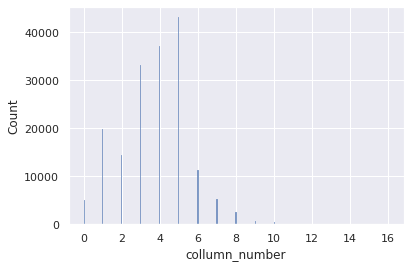

In [9]:
sns.histplot(data=htr_metadata['collumn_number'])

In [10]:
htr_metadata[htr_metadata['collumn_number']==3]['cleaned'].apply(lambda x : len(x)).describe()

count    33250.000000
mean        16.749414
std         10.939984
min          1.000000
25%          8.000000
50%         16.000000
75%         26.000000
max         58.000000
Name: cleaned, dtype: float64

In [11]:
htr_metadata['collumn_number']=htr_metadata['collumn_number'].astype(int) 
htr_metadata['collumn_number'].max()

16

In [12]:
for c in range(htr_metadata['collumn_number'].max()+1):
    stats = stats_length_column(htr_metadata, c)
    print('Column', c)
    print(stats)    

Column 0
count    4994.000000
mean        4.184822
std         2.561263
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        43.000000
Name: cleaned, dtype: float64
Column 1
count    19782.000000
mean         4.196643
std          2.023684
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max         47.000000
Name: cleaned, dtype: float64
Column 2
count    14495.000000
mean         6.590135
std          8.483411
min          1.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         69.000000
Name: cleaned, dtype: float64
Column 3
count    33250.000000
mean        16.749414
std         10.939984
min          1.000000
25%          8.000000
50%         16.000000
75%         26.000000
max         58.000000
Name: cleaned, dtype: float64
Column 4
count    37158.000000
mean         9.984741
std          8.035233
min          1.000000
25%          4.000000
50%          7.000000
75%    

In [13]:
print_all_mean(htr_metadata)

Mean length col 0 : 4.184821786143372
Mean length col 1 : 4.1966434132039225
Mean length col 2 : 6.590134529147982
Mean length col 3 : 16.749413533834588
Mean length col 4 : 9.984740836428225
Mean length col 5 : 13.868461948832138
Mean length col 6 : 10.110220797720798
Mean length col 7 : 7.348671544089334
Mean length col 8 : 3.6079613992762365
Mean length col 9 : 3.2639885222381637
Mean length col 10 : 3.5580912863070537
Mean length col 11 : 3.2244897959183674
Mean length col 12 : 3.0
Mean length col 13 : 2.7
Mean length col 14 : 3.0
Mean length col 15 : 10.0
Mean length col 16 : 21.0


#### Useful code snipet to detect strange mean based on threshold

In [ ]:
num_prob = 0
for page in sorted(htr_metadata['page_name'].unique()):
    page_htr_metatada = htr_metadata[htr_metadata['page_name']==page]
    
    
    length_col3 = mean_length_column(page_htr_metatada, 3)
    if length_col3 < 5:
        num_prob += 1
        print(page)
        
        print_all_mean(page_htr_metatada)
        
print('#problematic pages : ', num_prob)

### Page representation and vizualisation

In [15]:
matrix = mean_length_matrix(htr_metadata[htr_metadata['register']=='reg01'])
kmeans = KMeans(n_clusters=2).fit(matrix.fillna(0))

100%|██████████| 198/198 [00:04<00:00, 41.63it/s]


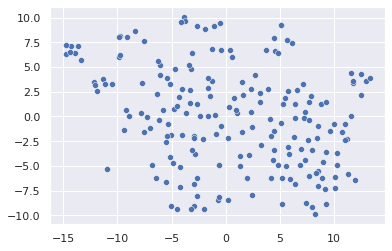

In [16]:
X_tsne = TSNE(n_components=2).fit_transform(matrix.fillna(0))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], legend='full')
plt.show()

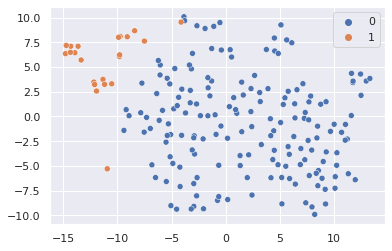

In [17]:
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=kmeans.labels_,legend='full')
plt.show()

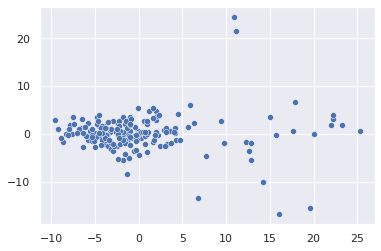

In [18]:
X_pca = PCA(n_components=2).fit_transform(matrix.fillna(0))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], legend='full')
plt.show()

<AxesSubplot:>

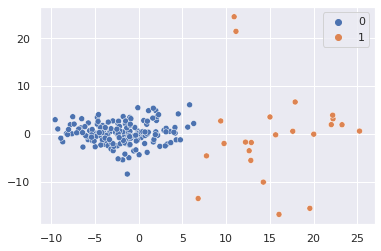

In [19]:
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],hue=kmeans.labels_, legend='full')

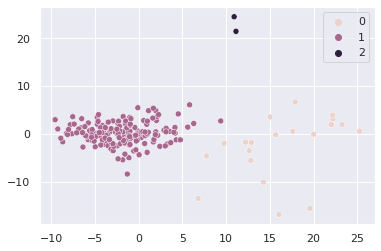

In [20]:
agglomerative = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(matrix.fillna(0))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=agglomerative.labels_,legend='full')
plt.show()

100%|██████████| 198/198 [00:04<00:00, 42.10it/s]


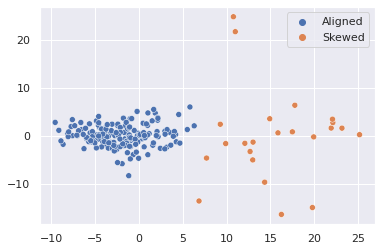

In [21]:
fig, axes = plt.subplots(1,1)
matrix = mean_length_matrix(htr_metadata[htr_metadata['register']=='reg01'])
kmeans = KMeans(n_clusters=2).fit(matrix[[0,1,2,3,4,5,6,7,8]].fillna(0))
aligned_cluster = np.argmax(np.bincount(kmeans.labels_))
skewed_cluster = int(not aligned_cluster)
legend_map = {aligned_cluster:'Aligned', skewed_cluster:'Skewed'}
labels = list(map(lambda x:legend_map[x], kmeans.labels_))
    
plot_pca(matrix[[0,1,2,3,4,5,6,7,8]], axes, labels)

### All registers - viz
Each point represent a page, the blue points are aligned pages, the orange one skewed. On the left we can see the data before any attemps to fix it and on the left the data after attempt to fix it.

100%|██████████| 65/65 [00:00<00:00, 66.12it/s]


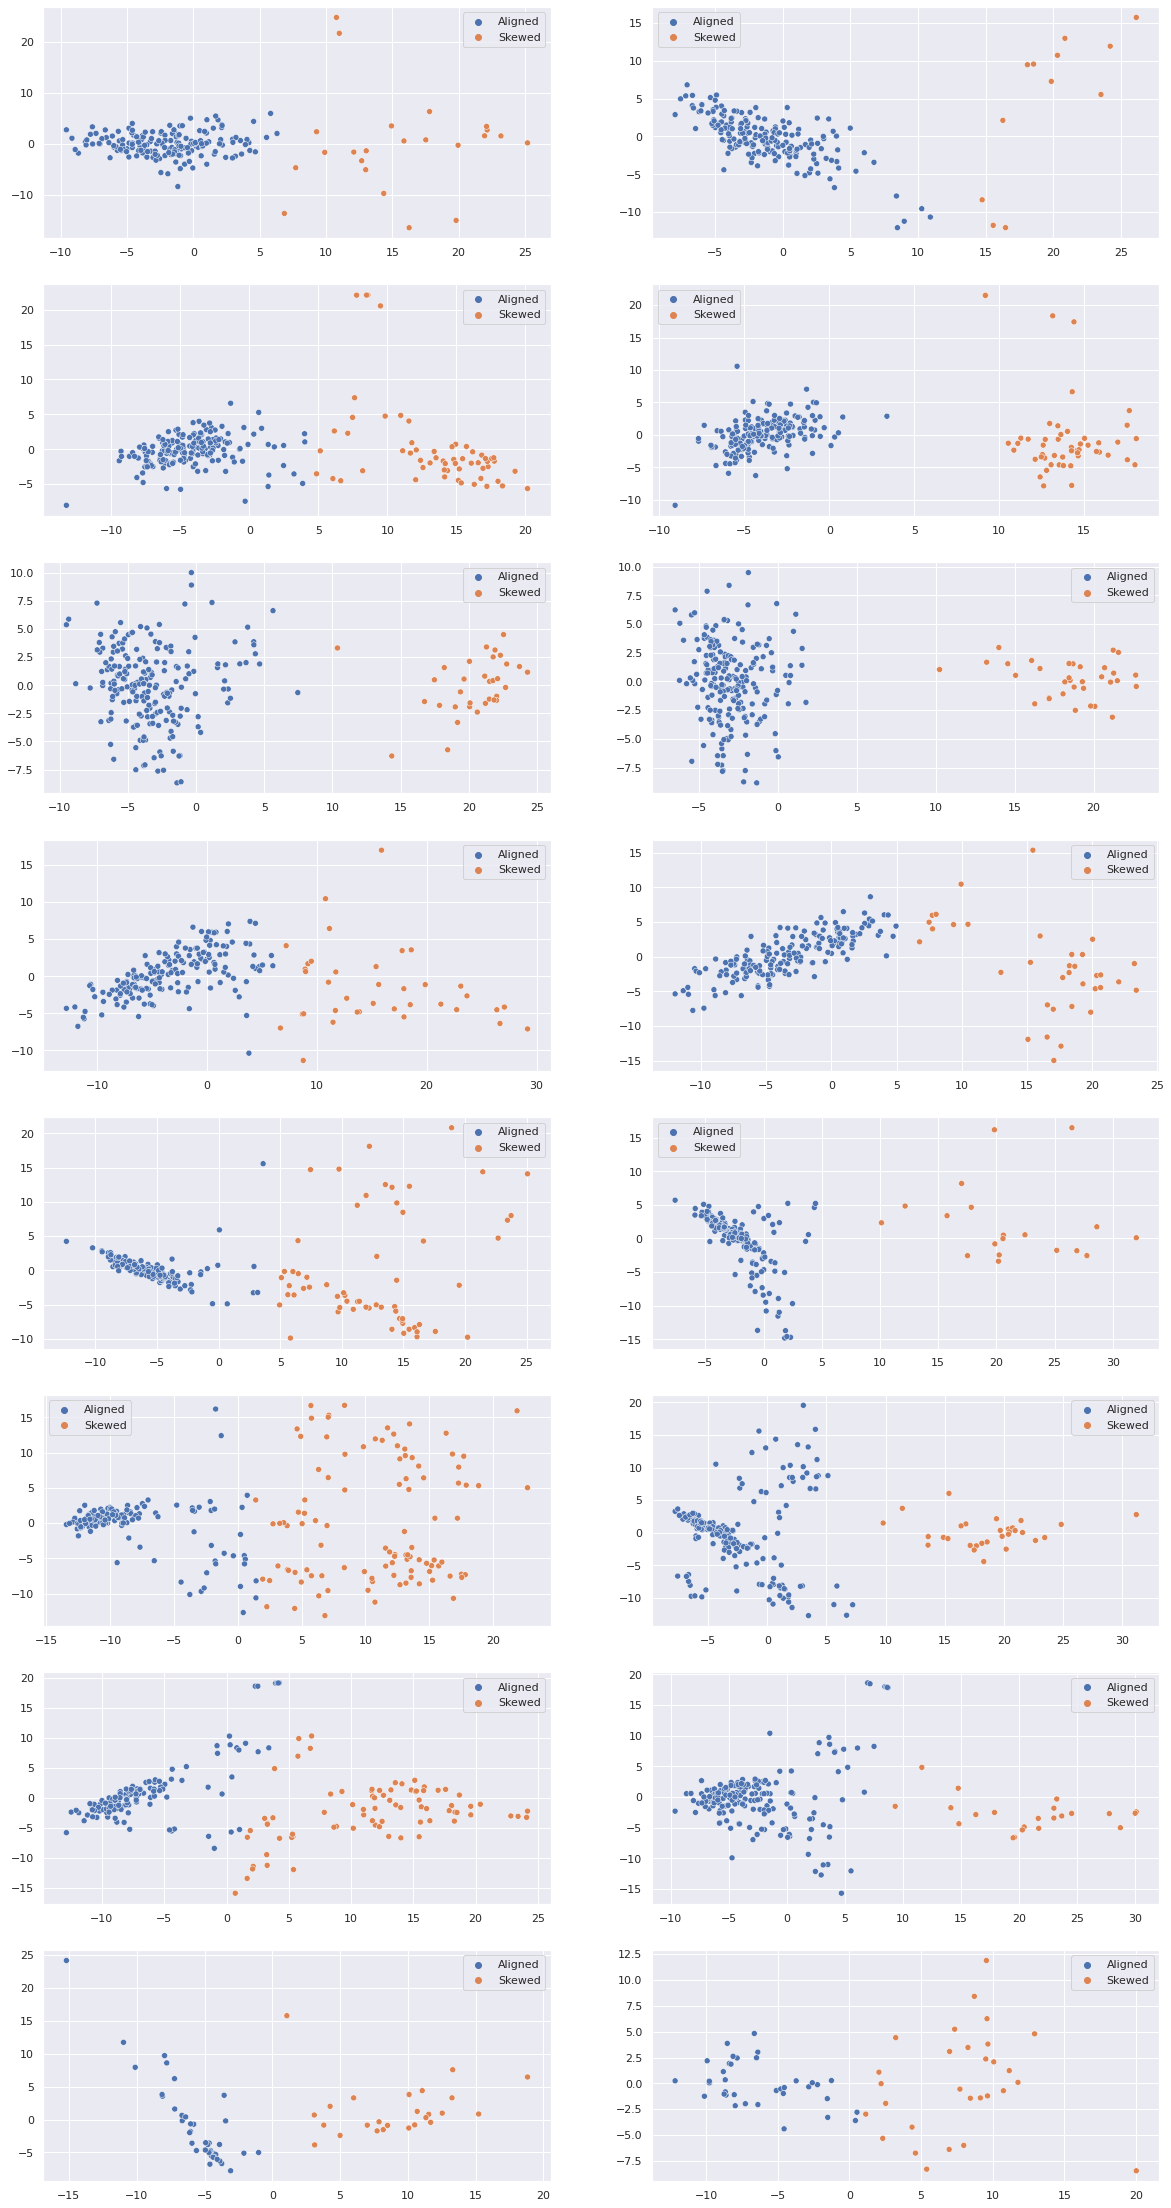

In [22]:
fig, axes = plt.subplots(8,2, figsize=(20,40), squeeze=False)
plot_line = 0
pages=[]
for i,register in enumerate(registers):
    htr_metadata = filter_columns(htr_metadata)
    matrix = mean_length_matrix(htr_metadata[htr_metadata['register']==register])
    labels, legend_map, kmeans = cluster_matrix(matrix)
    
    plot_col = 0
    plot_pca(matrix, axes[plot_line,plot_col], labels)
    
    matrix['cluster']=labels
    
    fixes = compute_fixes(htr_metadata, matrix, kmeans,legend_map)
    htr_metadata = apply_fixes(htr_metadata, fixes)
    htr_metadata = filter_columns(htr_metadata)
    
    matrix = mean_length_matrix(htr_metadata[htr_metadata['register']==register])
    labels, legend_map, kmeans = cluster_matrix(matrix)
    
    plot_col = 1
    plot_pca(matrix, axes[plot_line,plot_col], labels)
    
    matrix['cluster']=labels
    
    pages = pages + sorted(list(matrix[matrix['cluster']=='Aligned'].reset_index()['page_name']))
    plot_line+=1